In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score
from sklearn.gaussian_process import kernels
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.gaussian_process.kernels import Product
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

In [2]:
expedia_df = pd.read_csv('Expedia_cleaned.csv')

In [3]:
expedia_df['Name'].nunique()

292

In [4]:
## IQR = Q3 - Q1
## Price
price_q1 , price_q3 = np.percentile(expedia_df['TotalPrice'],[25,75])
priceIQR = (price_q3 - price_q1)
priceTUK = price_q3 + (1.5 * (priceIQR))

#remove outliers from 'Price'
#CODE HERE
expedia_df = expedia_df[~(expedia_df['TotalPrice'] > (priceTUK))]

In [5]:
expedia_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39259 entries, 0 to 40514
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Name                               39259 non-null  object 
 1   NumOfWeekendDays                   39259 non-null  int64  
 2   Nights                             39259 non-null  float64
 3   Score                              39259 non-null  float64
 4   Rating                             39259 non-null  float64
 5   Review                             39259 non-null  int64  
 6   Refundable                         39259 non-null  int64  
 7   Price                              39259 non-null  int64  
 8   WebIndex                           39259 non-null  int64  
 9   Includes_Airport shuttle included  39259 non-null  int64  
 10  Includes_Breakfast included        39259 non-null  int64  
 11  Includes_Kitchen                   39259 non-null  int

In [6]:
expedia_df_model = expedia_df.drop(['Name'],axis = 1)

In [7]:
expedia_df_model.describe()

,NumOfWeekendDays,Nights,Score,Rating,Review,Refundable,Price,WebIndex,Includes_Airport shuttle included,Includes_Breakfast included,...,District_Williamsburg,SnapShotMonth,SnapShotDay,CheckinMonth,CheckinDay,CheckoutMonth,CheckoutDay,TTT,LOS,TotalPrice
count,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,...,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000,39259.000000
mean,0.851499,2.928704,8.328358,7.454265,1145.796811,0.385389,337.759775,50.551007,0.009043,0.125551,...,0.004356,2.641407,10.907130,2.999338,15.746835,3.065514,16.661301,14.896992,3.928704,969.112305
std,0.831279,1.412280,0.697314,1.183899,673.396368,0.486693,132.807832,28.846295,0.094662,0.331347,...,0.065855,0.479593,12.059384,0.155395,8.402711,0.247433,8.567416,8.383838,1.412280,567.499770
min,0.000000,1.000000,5.000000,5.000000,1.000000,0.000000,110.000000,1.000000,0.000000,0.000000,...,0.000000,2.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,110.000000
25%,0.000000,2.000000,8.000000,7.000000,1000.000000,0.000000,255.000000,25.000000,0.000000,0.000000,...,0.000000,2.000000,1.000000,3.000000,9.000000,3.000000,10.000000,8.000000,3.000000,510.000000
50%,1.000000,3.000000,8.400000,7.000000,1003.000000,0.000000,314.000000,51.000000,0.000000,0.000000,...,0.000000,3.000000,3.000000,3.000000,16.000000,3.000000,17.000000,15.000000,4.000000,870.000000
75%,2.000000,4.000000,8.800000,8.000000,1223.000000,1.000000,391.000000,76.000000,0.000000,0.000000,...,0.000000,3.000000,27.000000,3.000000,23.000000,3.000000,24.000000,22.000000,5.000000,1344.000000
max,2.000000,5.000000,10.000000,10.000000,6339.000000,1.000000,1260.000000,100.000000,1.000000,1.000000,...,1.000000,3.000000,27.000000,4.000000,31.000000,4.000000,31.000000,29.000000,6.000000,2725.000000


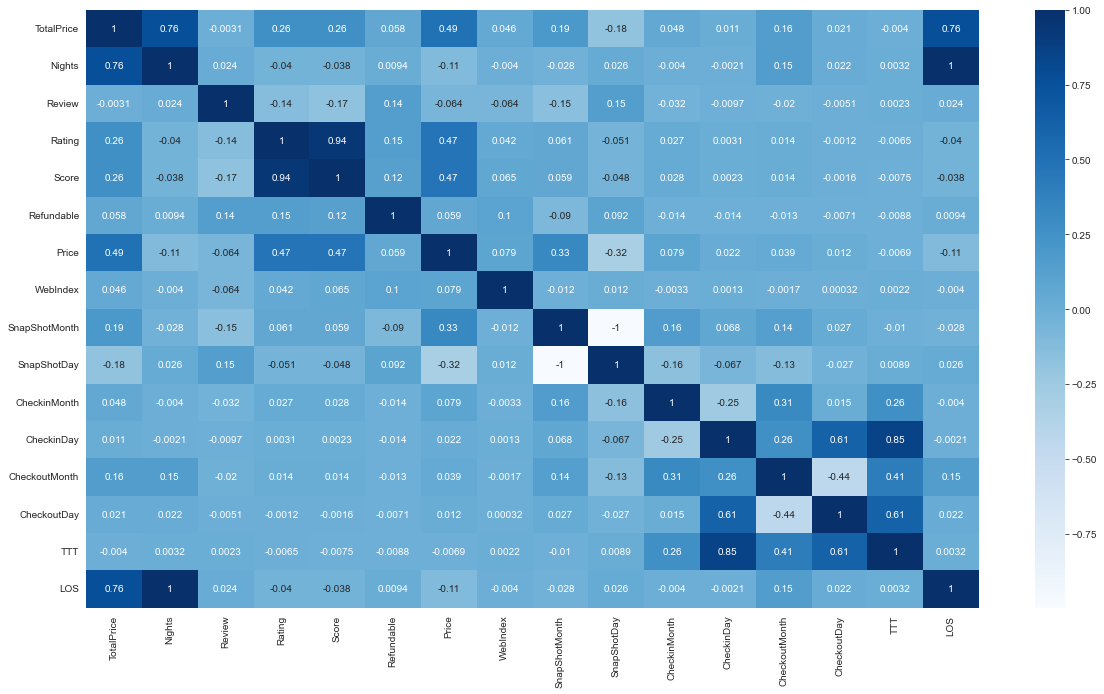

In [8]:
plt.figure(figsize=(20,11))
sns.heatmap(expedia_df_model[['TotalPrice','Nights','Review','Rating',
                             'Score','Refundable','Price','WebIndex','SnapShotMonth',
                             'SnapShotDay','CheckinMonth','CheckinDay','CheckoutMonth','CheckoutDay',
                             'TTT','LOS']].corr(),annot=True,cmap='Blues')
plt.show()

In [9]:
## Columns that can be dropped : Nights , Rating , SnapShotMonth , CheckinDay , LOS

# Genral functions

In [10]:
def residual_scatter(y_test,y_pred_test,y_train,y_pred_train):
    residualsTest = y_test - y_pred_test
    residualsTrain = y_train - y_pred_train
    plt.figure(figsize=(23,10))
    plt.scatter(y_pred_train,residualsTrain,color='skyblue',marker='.',label='Training Data')
    plt.scatter(y_pred_test,residualsTest,color='navy',marker='.',label='Testing Data')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0,xmin=-300,xmax=2700,color='r')
    plt.show()
    
def residual_hist(y_test,y_pred_test,y_train,y_pred_train):
    residualsTest = y_test - y_pred_test
    residualsTrain = y_train - y_pred_train
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    sns.distplot(residualsTest,hist=True,kde=True,ax=ax1)
    ax1.title.set_text('Test Residual Distribution')
    sns.distplot(residualsTrain,hist=True,kde=True,ax=ax2)
    ax2.title.set_text('Train Residual Distribution')
    plt.show()
    
def plot_tree(dt):
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=500)

    tree.plot_tree(dt,
           feature_names = list(X.columns), 
           filled = True);


# LinearRegression

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
X = expedia_df_model.drop(['TotalPrice','Nights', 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'Price'],axis = 1)
y = expedia_df_model['TotalPrice']

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [14]:
lr = LinearRegression()

In [15]:
lr.fit(X_train,y_train)

LinearRegression()

In [16]:
y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

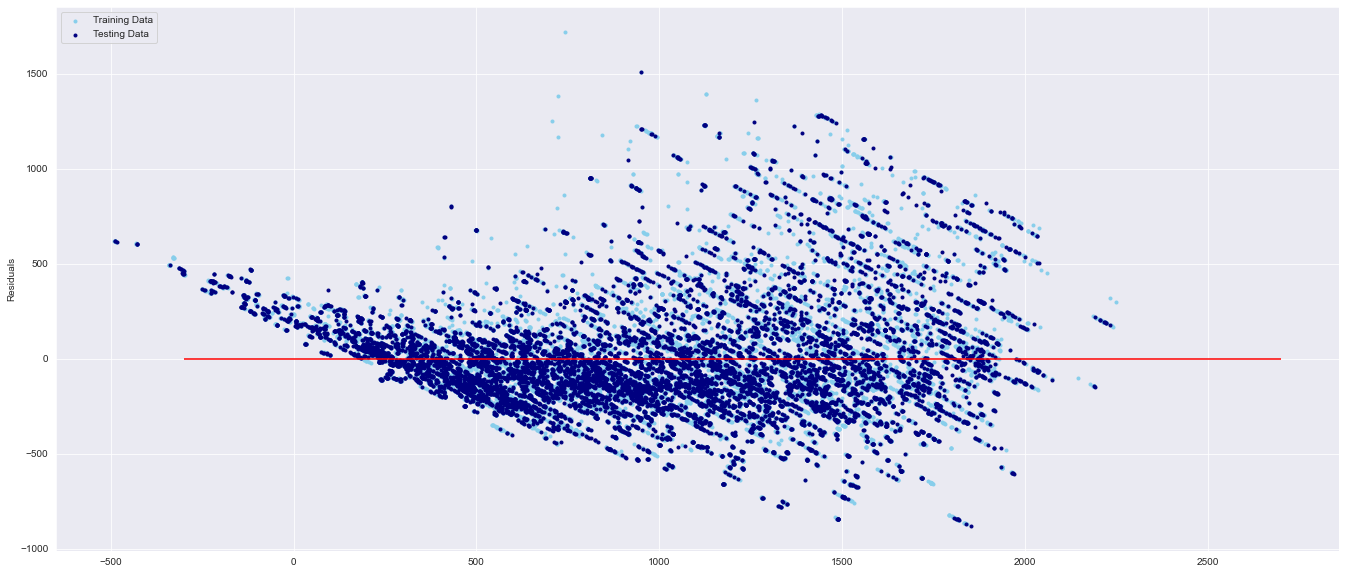

In [17]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

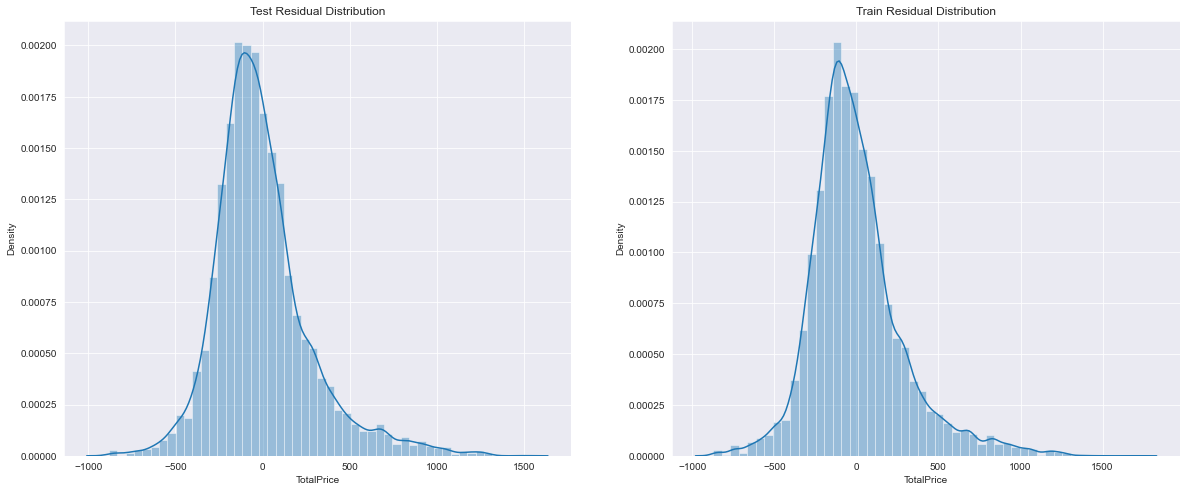

In [18]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [19]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head(20)

,Actual Value,Predicted Value,Difference
22164,277.0,204.616923,72.383077
17683,348.0,120.021074,227.978926
31290,705.0,640.473725,64.526275
37592,2144.0,1448.683480,695.316520
18817,396.0,412.240507,-16.240507
29025,375.0,614.276717,-239.276717
13013,1203.0,1306.185578,-103.185578
597,1066.0,904.633759,161.366241
14761,349.0,211.226116,137.773884
35123,976.0,947.512539,28.487461


In [20]:
lr1_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
lr1_MSE = mean_squared_error(y_test,y_pred_test)
lr1_MAE = mean_absolute_error(y_test,y_pred_test)
lr1_R2 = r2_score(y_test,y_pred_test)

print('RMSE',lr1_RMSE)
print('MSE',lr1_MSE)
print('MAE',lr1_MAE)
print('R2',lr1_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 277.16466094837386
MSE 76820.24927862704
MAE 201.86725978615186
R2 0.7625649302358972
R2 Train 0.7526318263685674


# DecisionTreeRegressor

In [21]:
from sklearn.tree import DecisionTreeRegressor

In [22]:
X = expedia_df_model.drop(['TotalPrice','Nights', 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'Price'],axis = 1)
y = expedia_df_model['TotalPrice']

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [24]:
dt = DecisionTreeRegressor()

In [25]:
param_grid = {
    'max_depth': [6,7,8,9,10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [26]:
gs = GridSearchCV(dt, param_grid=param_grid, cv=4, verbose= 5)

In [ ]:
gs.fit(X_train,y_train)

In [28]:
print('dt best param : '  , gs.best_params_)
print('dt best score : '  , gs.best_score_)

dt best param :  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5}
dt best score :  0.8847721550470988


In [30]:
dt = DecisionTreeRegressor(**gs.best_params_)

In [31]:
with tqdm(total=100) as pbar:
    for i in range(100):
        dt.fit(X_train, y_train)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


In [32]:
y_pred_test = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

In [33]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head(5)

,Actual Value,Predicted Value,Difference
22164,277.0,292.929577,-15.929577
17683,348.0,361.906977,-13.906977
31290,705.0,673.507042,31.492958
37592,2144.0,1580.286491,563.713509
18817,396.0,396.283525,-0.283525


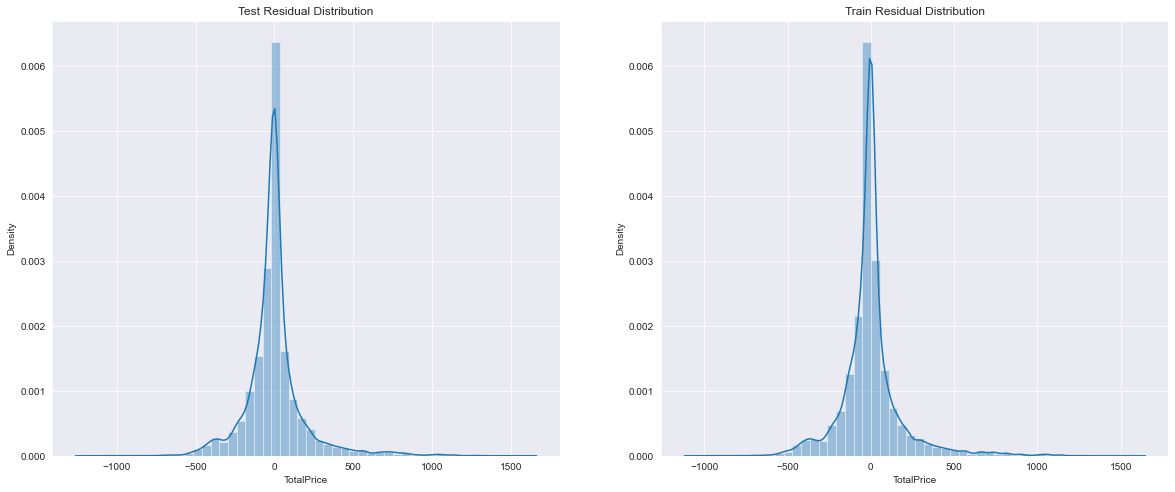

In [34]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [35]:
dt_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
dt_MSE = mean_squared_error(y_test,y_pred_test)
dt_MAE = mean_absolute_error(y_test,y_pred_test)
dt_R2 = r2_score(y_test,y_pred_test)

print('RMSE',dt_RMSE)
print('MSE',dt_MSE)
print('MAE',dt_MAE)
print('R2',dt_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 189.7797260421194
MSE 36016.34441662189
MAE 110.85667207814652
R2 0.8886811312185134
R2 Train 0.8934560266854937


# GaussianProcessRegressor

In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF, DotProduct, RationalQuadratic, Sum, ExpSineSquared ,ConstantKernel

In [37]:
expedia_df2 = expedia_df_model[['NumOfWeekendDays','Nights','Score','Rating','Review','Refundable','WebIndex','SnapShotMonth',
                               'SnapShotDay','CheckinMonth','CheckinDay','CheckoutMonth','TTT','LOS','Price','TotalPrice']]

In [38]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(expedia_df2), columns=expedia_df2.columns)

In [39]:
sample_df = df_normalized.sample(frac=0.20)

In [40]:
sample_df.shape

(7852, 16)

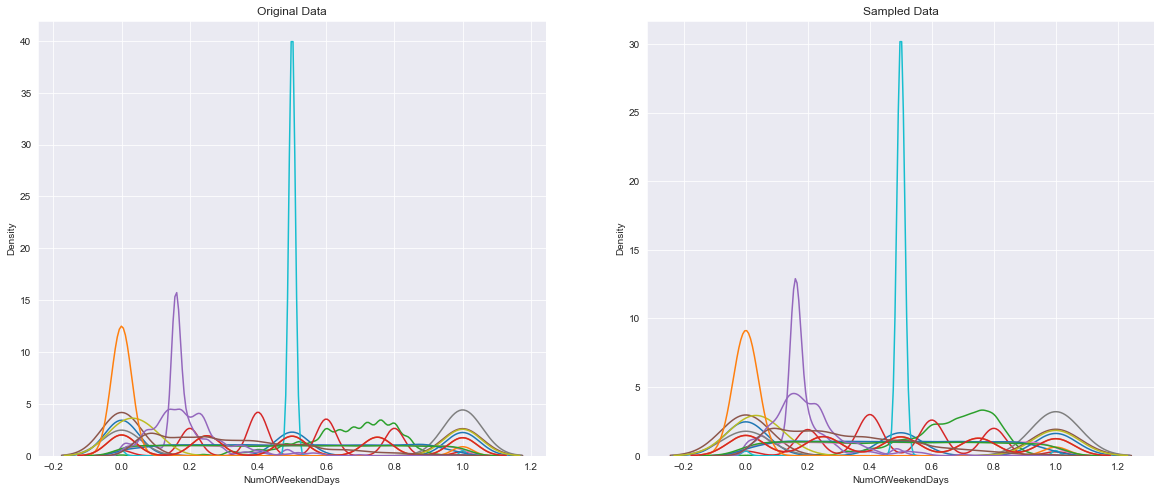

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
for i,col in enumerate(df_normalized[:-1]):
    sns.kdeplot(df_normalized[col],ax=ax1)
for i,col in enumerate(sample_df[:-1]):
    sns.kdeplot(sample_df[col],ax=ax2)
ax1.title.set_text('Original Data')
ax2.title.set_text('Sampled Data')

In [42]:
X = sample_df.drop(['TotalPrice','Nights', 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'Price'],axis = 1)
y = sample_df.TotalPrice

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [44]:
kernels = [Product(DotProduct()+WhiteKernel(),RBF()),
         Product(DotProduct()+WhiteKernel(),Matern())]

In [45]:
param_grid = [{'kernel__k1__k2__noise_level':[0.2,0.5,0.7],
              'kernel__k2__length_scale':[0.8,1.0,1.2]},
             {'kernel__k1__k2__noise_level':[0.2,0.5,0.7],
             'kernel__k2__length_scale':[0.8,1.0,1.2],
             'kernel__k2__nu':[1.5,2.5]}]

In [ ]:
best_score  = -np.inf
for i,kernel in enumerate(kernels):
    gpr = GaussianProcessRegressor(kernel=kernel)
    gs = GridSearchCV(gpr, param_grid[i], cv=3,verbose=5)
    gs.fit(X_train,y_train)
    if gs.best_score_ > best_score:
        best_score = gs.best_score_
        best_kernel = gs.best_estimator_.kernel_

In [47]:
print('Best kernel is : ',best_kernel)
print('Score : ',best_score)

Best kernel is :  DotProduct(sigma_0=0.0462) + WhiteKernel(noise_level=0.0105) * Matern(length_scale=8.05, nu=1.5)
Score :  0.7525599343187661


In [48]:
gpr = GaussianProcessRegressor(kernel=best_kernel)

In [49]:
with tqdm(total=100) as pbar:
    for i in range(100):
        gpr.fit(X_train, y_train)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [16:08:40<00:00, 581.20s/it]


In [50]:
y_pred_train, y_pred_tr_std = gpr.predict(X_train, return_std=True)
y_pred_test, y_pred_te_std = gpr.predict(X_test, return_std=True)

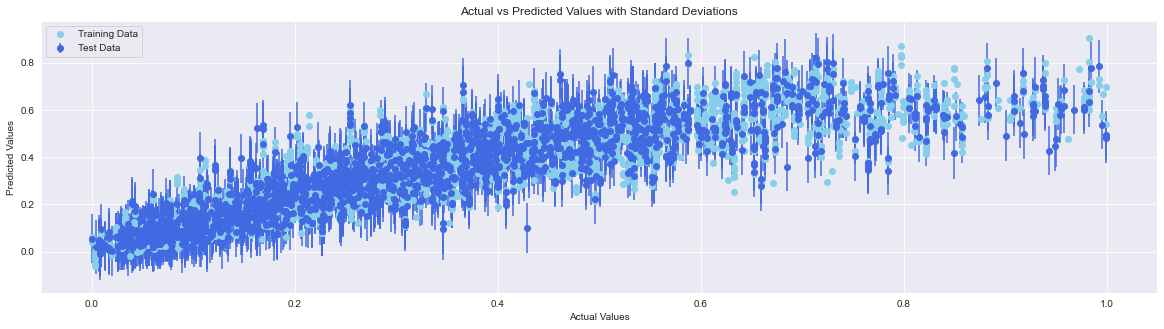

In [51]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.errorbar(y_test, y_pred_test, yerr=y_pred_te_std, fmt='o', color='royalblue', label='Test Data')
ax.plot(y_train, y_pred_train, 'o', color='skyblue', label='Training Data')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual vs Predicted Values with Standard Deviations')
ax.legend()

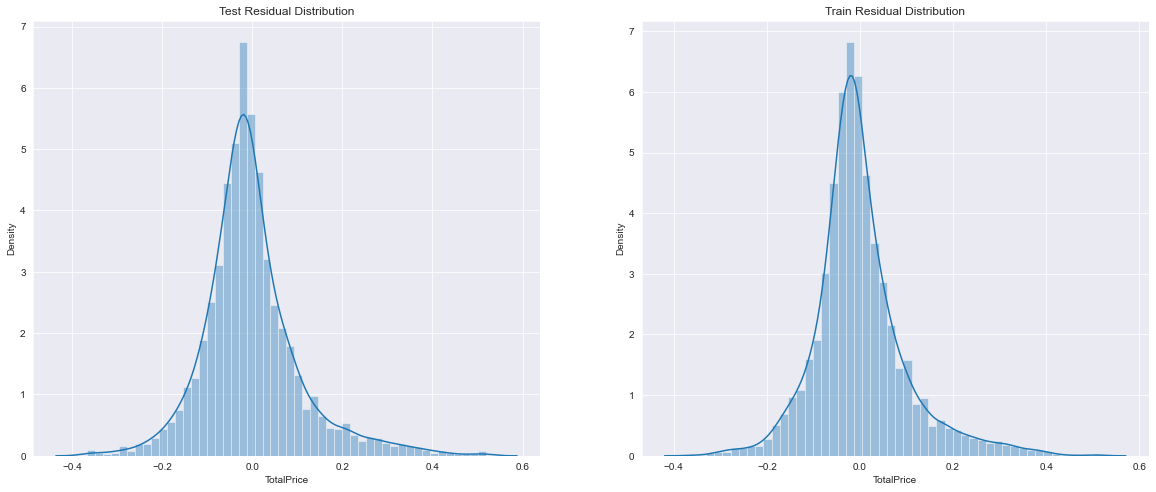

In [52]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [53]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
17077,0.462715,0.505911,-0.043196
32255,0.199618,0.259695,-0.060078
18477,0.451243,0.435816,0.015427
11200,0.534608,0.464606,0.070002
25025,0.243977,0.145180,0.098797


In [54]:
gpr_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
gpr_MSE = mean_squared_error(y_test,y_pred_test)
gpr_MAE = mean_absolute_error(y_test,y_pred_test)
gpr_R2 = r2_score(y_test,y_pred_test)

print('RMSE',gpr_RMSE)
print('MSE',gpr_MSE)
print('MAE',gpr_MAE)
print('R2',gpr_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 0.10822151621568975
MSE 0.011711896572022798
MAE 0.07615991485890851
R2 0.7557618277870598
R2 Train 0.7914284301338975


# ElasticNet

In [55]:
from sklearn.linear_model import ElasticNet

In [56]:
X = expedia_df_model.drop(['TotalPrice','Nights', 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'Price'],axis = 1)
y = expedia_df_model['TotalPrice']

In [57]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [58]:
en = ElasticNet()

In [59]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.25, 0.5, 0.75],
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'max_iter': [1000, 5000, 10000],
}

In [60]:
gs = GridSearchCV(en, param_grid=param_grid, cv=4, verbose= 5)

In [ ]:
gs.fit(X_train,y_train)

In [63]:
print('en best param : '  , gs.best_params_)
print('en best score : '  , gs.best_score_)

en best param :  {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.75, 'max_iter': 1000, 'normalize': False}
en best score :  0.7477829476494878


In [64]:
en = ElasticNet(**gs.best_params_)

In [65]:
with tqdm(total=100) as pbar:
    for i in range(100):
        en.fit(X_train, y_train)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s]


In [66]:
y_pred_test = en.predict(X_test)
y_pred_train = en.predict(X_train)

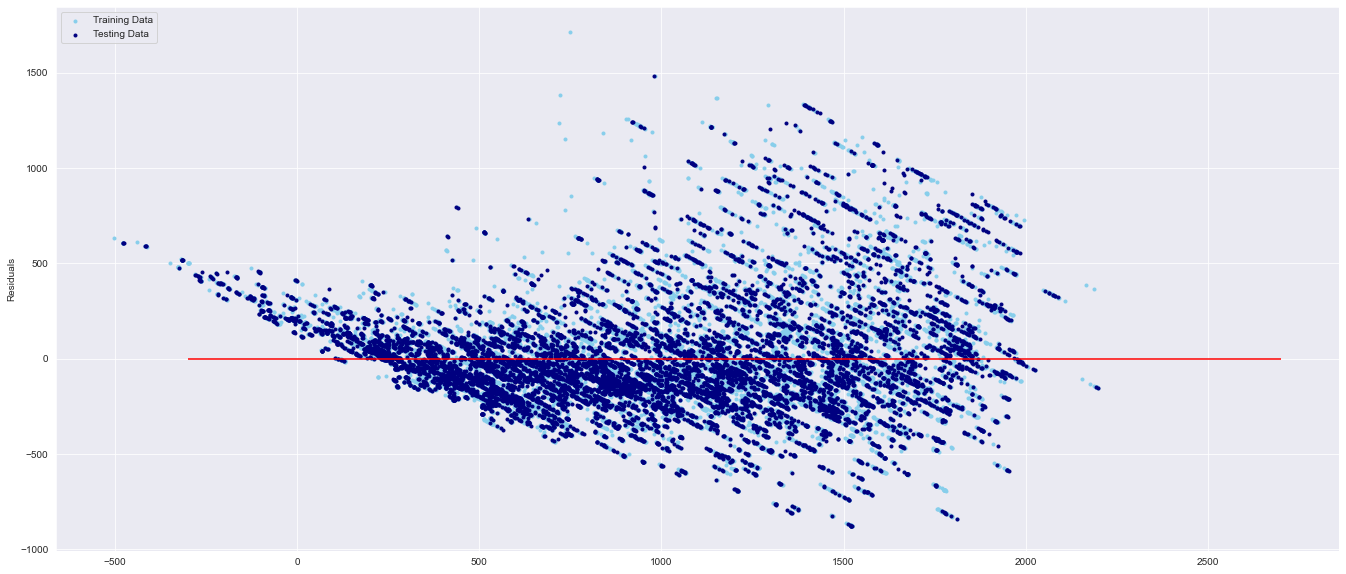

In [67]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

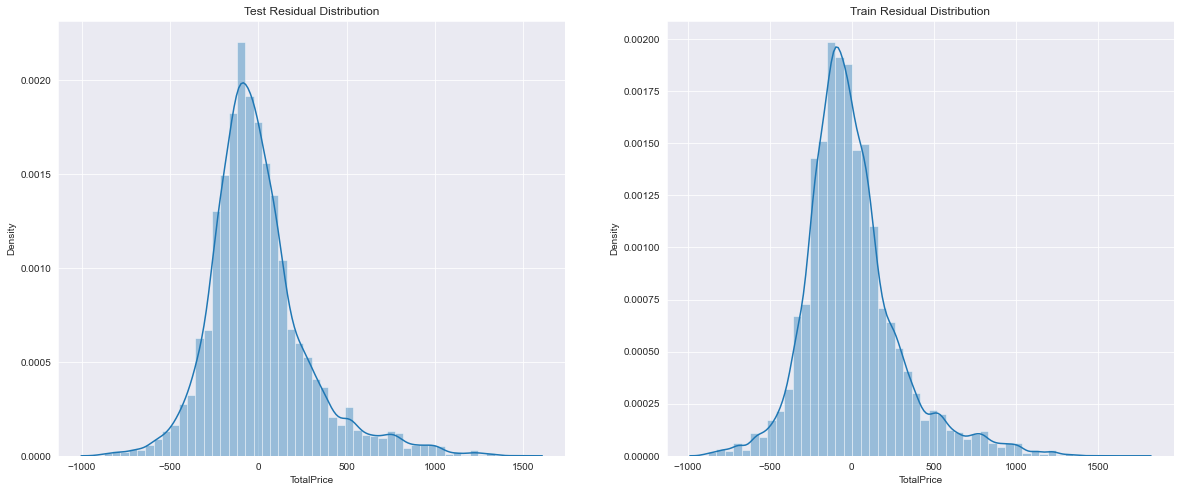

In [68]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [69]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
22164,277.0,216.927094,60.072906
17683,348.0,133.436566,214.563434
31290,705.0,603.872089,101.127911
37592,2144.0,1409.832711,734.167289
18817,396.0,420.276187,-24.276187


In [70]:
es_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
es_MSE = mean_squared_error(y_test,y_pred_test)
es_MAE = mean_absolute_error(y_test,y_pred_test)
es_R2 = r2_score(y_test,y_pred_test)

print('RMSE',es_RMSE)
print('MSE',es_MSE)
print('MAE',es_MAE)
print('R2',es_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 279.6482451471747
MSE 78203.14101389432
MAE 202.25898812686285
R2 0.7582907056828309
R2 Train 0.7483115587268272


# RandomForestRegressor

In [85]:
from sklearn.ensemble import RandomForestRegressor

In [86]:
X = expedia_df_model.drop(['TotalPrice','Nights', 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'Price'],axis = 1)
y = expedia_df_model['TotalPrice']

In [87]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [88]:
rf = RandomForestRegressor()

In [89]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [7,8,9,10],
    'min_samples_split': [2,3,4, 5],
    'min_samples_leaf': [2, 4,5],
    'max_features': ['sqrt', 'log2', None]  
}

In [90]:
gs = GridSearchCV(rf, param_grid=param_grid, cv=3, verbose= 5)

In [ ]:
gs.fit(X_train,y_train)

In [92]:
print('rf best param : '  , gs.best_params_)
print('rf best score : '  , gs.best_score_)

rf best param :  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
rf best score :  0.9038349977318131


In [93]:
rf = RandomForestRegressor(**gs.best_params_)

In [94]:
with tqdm(total=100) as pbar:
    for i in range(100):
        rf.fit(X_train, y_train)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:32<00:00,  6.92s/it]


In [95]:
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

In [96]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
22164,277.0,277.619346,-0.619346
17683,348.0,343.757528,4.242472
31290,705.0,691.425026,13.574974
37592,2144.0,1585.839290,558.160710
18817,396.0,395.295407,0.704593


In [97]:
rf_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
rf_MSE = mean_squared_error(y_test,y_pred_test)
rf_MAE = mean_absolute_error(y_test,y_pred_test)
rf_R2 = r2_score(y_test,y_pred_test)

print('RMSE',rf_RMSE)
print('MSE',rf_MSE)
print('MAE',rf_MAE)
print('R2',rf_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 175.31035513658767
MSE 30733.720618116487
MAE 102.57030227101296
R2 0.9050085990660385
R2 Train 0.9087305800090348


# XGBoostRegressor

In [128]:
from xgboost import XGBRegressor

In [129]:
X = expedia_df_model.drop(['TotalPrice','Nights', 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'Price'],axis = 1)
y = expedia_df_model['TotalPrice']

In [130]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [131]:
estimators = [
    ('encoder',TargetEncoder()),
    ('clf',XGBRegressor())
]

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_pa

In [132]:
from skopt import BayesSearchCV
from skopt.space.space import Real ,Categorical,Integer

search_space = {
    'clf__max_depth':Integer(2,8),
    'clf__learning_rate':Real(0.001,1.0,prior='log-uniform'),
    'clf__subsample':Real(0.5,1.0),
    'clf__colsample_bytree':Real(0.5,1.0),
    'clf__colsample_bylever':Real(0.5,1.0),
    'clf__colsample_bynode':Real(0.5,1.0),
    'clf__reg_alpha':Real(0.0,10.0),
    'clf__reg_lamda':Real(0.0,10.0),
    'clf__gamma':Real(0.0,10.0)
    
}

opt = BayesSearchCV(pipe,search_space,cv=3,n_iter=10,scoring='r2',random_state=8)

In [ ]:
opt.fit(X_train,y_train)

In [134]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder(cols=[])),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None,
                              colsample_bylever=0.9425384185492701,
                              colsample_bynode=0.9095956806239844,
                              colsample_bytree=0.706128679361455,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=1.65981354...
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.7929828265552742, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth

In [135]:
y_pred_test = opt.predict(X_test)
y_pred_train = opt.predict(X_train)

In [136]:
opt.best_estimator_.steps

[('encoder', TargetEncoder(cols=[])),
 ('clf',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bylever=0.9425384185492701,
               colsample_bynode=0.9095956806239844,
               colsample_bytree=0.706128679361455, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=1.6598135411398998, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.7929828265552742, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, ...))]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

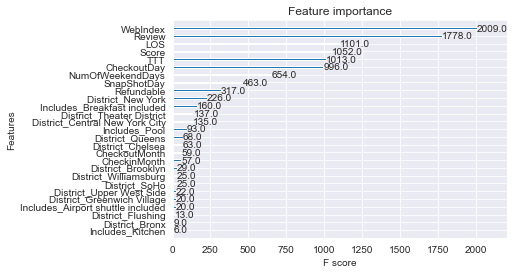

In [137]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

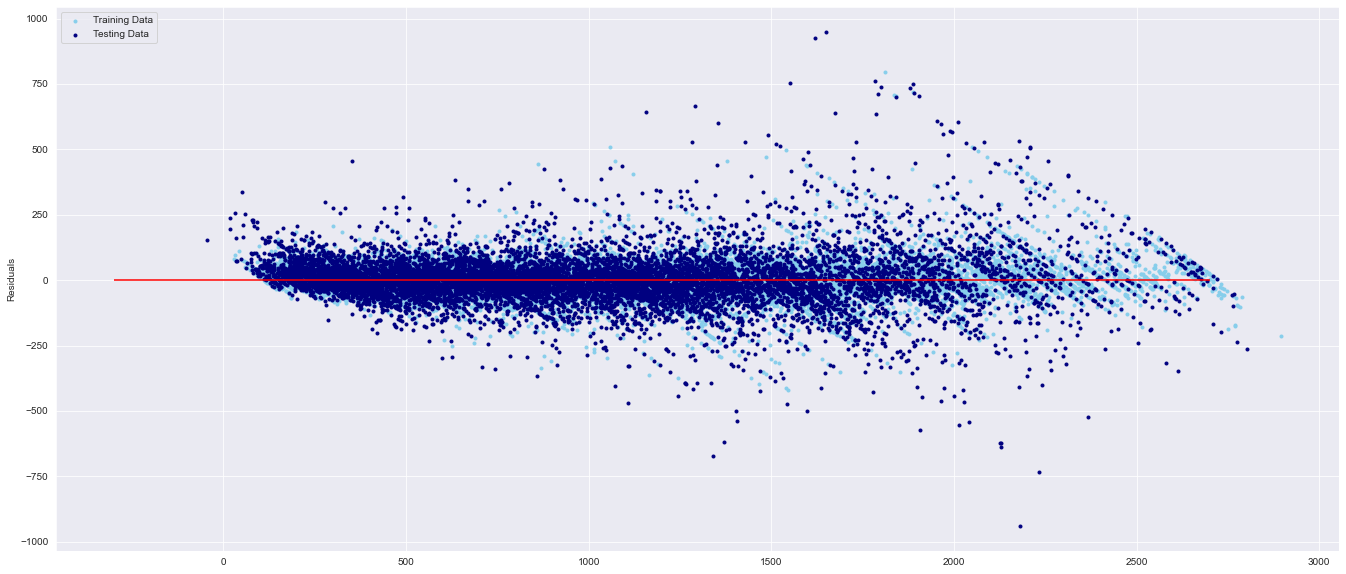

In [138]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

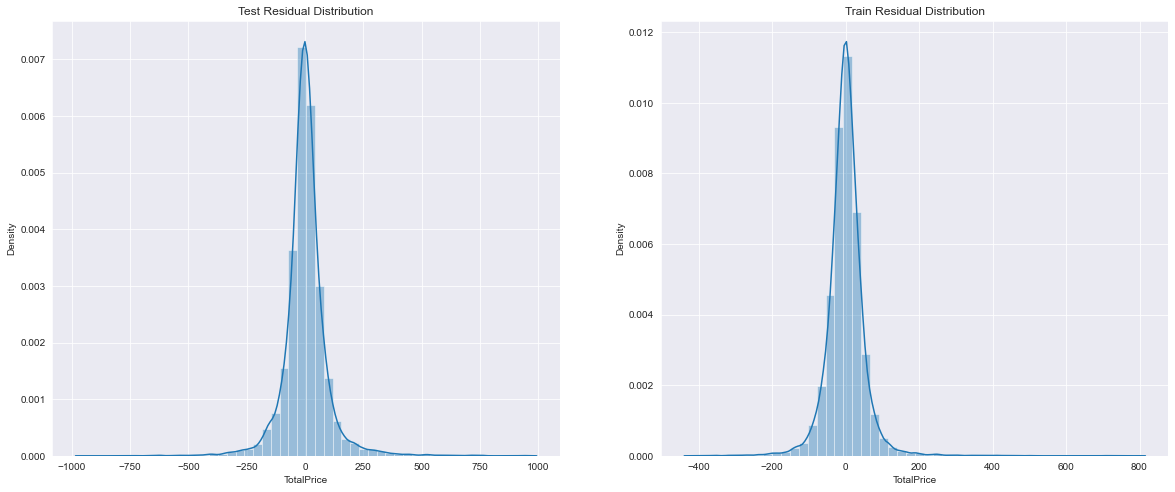

In [139]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [140]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
22164,277.0,325.433960,-48.433960
17683,348.0,330.728699,17.271301
31290,705.0,725.228210,-20.228210
37592,2144.0,2226.776611,-82.776611
18817,396.0,380.166412,15.833588


In [141]:
opt_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
opt_MSE = mean_squared_error(y_test,y_pred_test)
opt_MAE = mean_absolute_error(y_test,y_pred_test)
opt_R2 = r2_score(y_test,y_pred_test)

print('RMSE',opt_RMSE)
print('MSE',opt_MSE)
print('MAE',opt_MAE)
print('R2',opt_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 94.36489587824661
MSE 8904.733574112326
MAE 59.23830954379553
R2 0.9724773603671663
R2 Train 0.9915581002081018


## Models summary

In [113]:
models = pd.DataFrame({'Model' : ['LinearRegression' ,  'DecisionTree' ,
                                  'GPR','ElasticNet',
                                 'RandomForestRegressor','XGBoost'],
                      'RMSE' : [lr1_RMSE , dt_RMSE ,gpr_RMSE,es_RMSE,rf_RMSE,opt_RMSE],
                      'MSE' : [lr1_MSE , dt_MSE ,gpr_MSE,es_MSE,rf_MSE,opt_MSE],
                      'MAE' : [lr1_MAE , dt_MAE ,gpr_MAE,es_MAE,rf_MAE,opt_MAE],
                      'R2' : [lr1_R2 , dt_R2 ,gpr_R2,es_R2,rf_R2,opt_R2]})

In [114]:
models.sort_values(by = 'R2', ascending = False)

,Model,RMSE,MSE,MAE,R2
5,XGBoost,94.364896,8904.733574,59.238310,0.972477
4,RandomForestRegressor,175.310355,30733.720618,102.570302,0.905009
1,DecisionTree,189.779726,36016.344417,110.856672,0.888681
0,LinearRegression,277.164661,76820.249279,201.867260,0.762565
3,ElasticNet,279.648245,78203.141014,202.258988,0.758291
2,GPR,0.108222,0.011712,0.076160,0.755762


# Experiment with the best scoring model - XGBoost

### In this experiment we will check if it is possible to predict the price of the hotel while taking TTT <= 25 and to predict the price for TTT > 25

In [115]:
X = expedia_df_model.drop(['TotalPrice','Nights', 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'Price'],axis = 1)
y = expedia_df_model['TotalPrice']

In [116]:
X_train = expedia_df_model[expedia_df_model['TTT'] <= 25].drop(['TotalPrice','Nights', 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'Price'], axis=1)
y_train = expedia_df_model[expedia_df_model['TTT'] <= 25]['TotalPrice']
X_test = expedia_df_model[expedia_df_model['TTT'] > 25].drop(['TotalPrice','Nights', 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'Price'], axis=1)
y_test = expedia_df_model[expedia_df_model['TTT'] > 25]['TotalPrice']

In [117]:
estimators = [
    ('encoder',TargetEncoder()),
    ('clf',XGBRegressor())
]

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_pa

In [118]:
search_space = {
    'clf__max_depth':Integer(2,8),
    'clf__learning_rate':Real(0.001,1.0,prior='log-uniform'),
    'clf__subsample':Real(0.5,1.0),
    'clf__colsample_bytree':Real(0.5,1.0),
    'clf__colsample_bylever':Real(0.5,1.0),
    'clf__colsample_bynode':Real(0.5,1.0),
    'clf__reg_alpha':Real(0.0,10.0),
    'clf__reg_lamda':Real(0.0,10.0),
    'clf__gamma':Real(0.0,10.0)
    
}

opt = BayesSearchCV(pipe,search_space,cv=3,n_iter=10,scoring='r2',random_state=8)

In [ ]:
opt.fit(X_train,y_train)

In [120]:
y_pred_test = opt.predict(X_test)
y_pred_train = opt.predict(X_train)

In [121]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder(cols=[])),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None,
                              colsample_bylever=0.6854728136721551,
                              colsample_bynode=0.9716292421559054,
                              colsample_bytree=0.9999681720272138,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=9.2693427...
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.4165635668761467, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

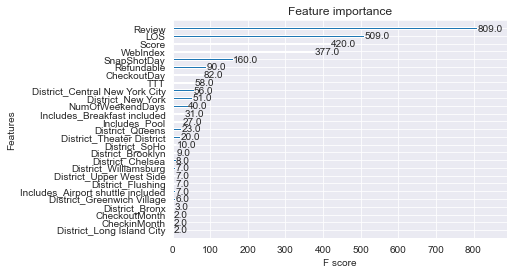

In [122]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

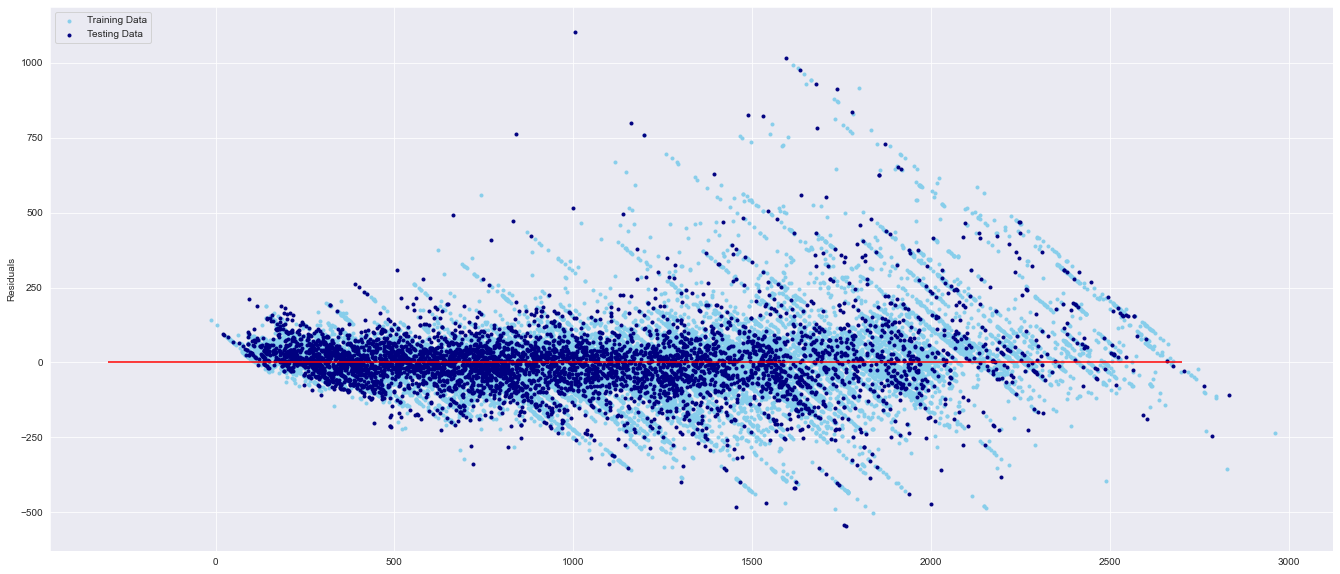

In [123]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

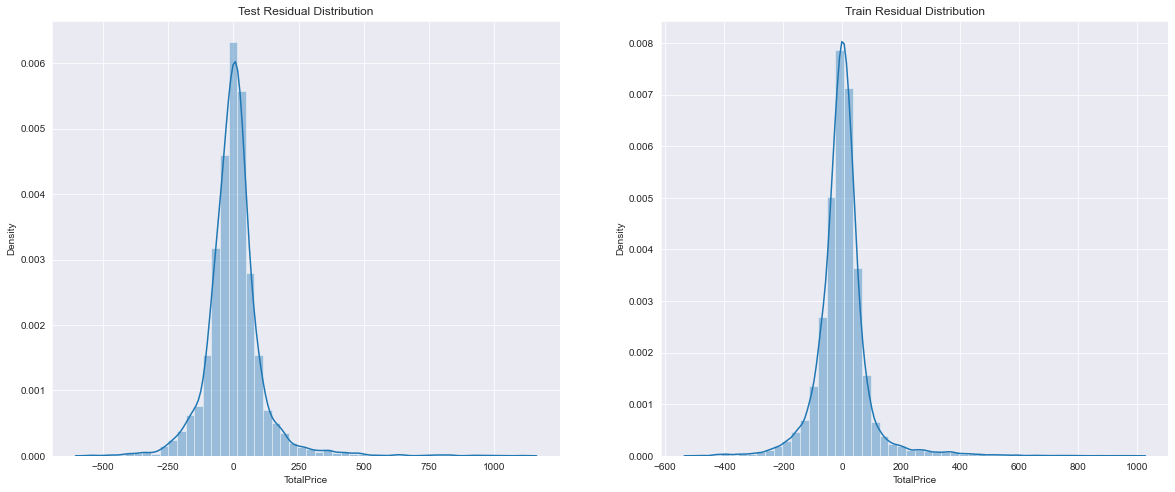

In [124]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [126]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
12274,423.0,407.672913,15.327087
12275,446.0,471.012360,-25.012360
12276,181.0,210.900650,-29.900650
12277,155.0,138.608871,16.391129
12278,187.0,129.356445,57.643555


In [127]:
opt1_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
opt1_MSE = mean_squared_error(y_test,y_pred_test)
opt1_MAE = mean_absolute_error(y_test,y_pred_test)
opt1_R2 = r2_score(y_test,y_pred_test)

print('RMSE',opt1_RMSE)
print('MSE',opt1_MSE)
print('MAE',opt1_MAE)
print('R2',opt1_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 108.60389578474262
MSE 11794.806179623234
MAE 68.64896438579912
R2 0.9637427180126362
R2 Train 0.9746256593590202
